# Lab 3: Classification (Part 2) and Model Selection

## Name: Shamith Achanta (shamith2)

### Due September 16, 2019 11:59 PM

**Logistics and Lab Submission**

See the [course website](https://courses.engr.illinois.edu/ece365/fa2019/logisticsvvv.html). Remember that all labs count equally, despite the labs being graded from a different number of total points).

**What You Will Need To Know For This Lab**

This lab covers a few more basic classifiers which can be used for M-ary classification:
- Naive Bayes
- Logistic Regression
- Support Vector Machines

as well as cross-validation, a tool for model selection and assessment.
 
There are some problems which have short answer questions. <b>Do not write an essay -- a few (1-2) complete sentences will suffice.</b>

<b>Also, be clear about your answers</b>. For example, if a question asks you "Which classifier would you choose?", be unequivocal about which classifier you would choose (and why); as engineers, part of your job is to make design decisions and justify them in the context of the alternatives and in the application. 

Remember in many applications, the end goal is not always "run a classifier", like in a homework problem, but is to use the output of the classifier in the context of the problem at hand (e.g. detecting spam, identifying cancer, etc.). Because of this, some of our Engineering Design-type questions are designed to get you to think about the entire design problem at a high level.


**Warning: Do not train on your test sets. You will automatically have your score halved for a problem if you train on your test data.**

**Preamble (don't change this)**

In [1]:
%pylab inline
import numpy as np
from sklearn import neighbors
from sklearn import svm
from sklearn import model_selection
from numpy import genfromtxt
from sklearn.preprocessing import MinMaxScaler
import glob

Populating the interactive namespace from numpy and matplotlib


### Problem 1: Spam Detection (90 points)

In this problem, you will be constructing a crude spam detector. As you all know, when you receive an e-mail, it can be divided into one of two types: ham (useful mail, label $-1$) and spam (junk mail, label $+1$). In the [olden days](http://www.paulgraham.com/spam.html), people tried writing a bunch of rules to detect spam. However, it was quickly seen that machine learning approaches work fairly well for a little bit of work. 

You will be designing a spam detector by applying some of the classification techniques you learned in class to a batch of emails used to train and test [SpamAssassin](http://spamassassin.apache.org/), a leading anti-spam software package. 

Let the *vocabulary* of a dataset be a list of all terms occuring in a data set. So, for example, a vocabulary could be ["cat","dog","chupacabra", "aerospace", ...]. 

Our features will be based only the frequencies of terms in our vocabulary occuring in the e-mails (such an approach is called a *bag of words* approach, since we ignore the positions of the terms in the emails). The $j$-th feature is the number of times term $j$ in the vocabulary occurs in the email. If you are interested in further details on this model, you can see Chapters 6 and 13 in [Manning's Book](http://nlp.stanford.edu/IR-book/).

You will use the following classifiers in this problem:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultinomialNB (Naive Bayes Classifier with Multinomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (1-Nearest Neighbor Classifier)

In the context of the Bernoulli Model for Naive Bayes, scikit-learn will binarize the features by interpretting the $j$-th feature to be $1$ if the $j$-th term in the vocabulary occurs in the email and $0$ otherwise. This is a categorical Naive Bayes model, with binary features. While we did not discuss the multinomial model in class, it operates directly on the frequencies of terms in the vocabulary, and is discussed in Section 13.2 in [Manning's Book](http://nlp.stanford.edu/IR-book/) (though you do not need to read this reference). Both the Bernoulli and Multinomial models are commonly used for Naive Bayes in text classification. 

A sample Ham email is:

    From nic@starflung.com  Mon Jun 24 17:06:54 2002
    Return-Path: 7910726.0.27May2002215326@mp.opensrs.net
    Delivery-Date: Tue May 28 02:53:28 2002
    Received: from mp.opensrs.net (mp.opensrs.net [216.40.33.45]) by
        dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4S1rSe14718 for
        <zzz@spamassassin.taint.org>; Tue, 28 May 2002 02:53:28 +0100
    Received: (from popensrs@localhost) by mp.opensrs.net (8.9.3/8.9.3) id
        VAA04361; Mon, 27 May 2002 21:53:26 -0400
    Message-Id: <7910726.0.27May2002215326@mp.opensrs.net>
    Date: Mon, 27 May 2002 21:53:26 -0500 (EST)
    From: "Starflung NIC" <nic@starflung.com>
    To: <zzz@spamassassin.taint.org>
    Subject: Automated 30 day renewal reminder 2002-05-27
    X-Keywords: 

    The following domains that are registered as belonging
    to you are due to expire within the next 60 days. If
    you would like to renew them, please contact
    nic@starflung.com; otherwise they will be deactivated
    and may be registered by another.


    Domain Name, Expiry Date
    nutmegclothing.com, 2002-06-26
    
    
A sample Spam email is: 

    From jjj@mymail.dk  Fri Aug 23 11:03:31 2002
    Return-Path: <jjj@mymail.dk>
    Delivered-To: zzzz@localhost.example.com
    Received: from localhost (localhost [127.0.0.1])
        by phobos.labs.example.com (Postfix) with ESMTP id 478B54415C
        for <zzzz@localhost>; Fri, 23 Aug 2002 06:02:57 -0400 (EDT)
    Received: from mail.webnote.net [193.120.211.219]
        by localhost with POP3 (fetchmail-5.9.0)
        for zzzz@localhost (single-drop); Fri, 23 Aug 2002 11:02:57 +0100 (IST)
    Received: from smtp.easydns.com (smtp.easydns.com [205.210.42.30])
        by webnote.net (8.9.3/8.9.3) with ESMTP id IAA08912;
        Fri, 23 Aug 2002 08:13:36 +0100
    From: jjj@mymail.dk
    Received: from mymail.dk (unknown [61.97.34.233])
        by smtp.easydns.com (Postfix) with SMTP
        id 7484A2F85C; Fri, 23 Aug 2002 03:13:31 -0400 (EDT)
    Reply-To: <jjj@mymail.dk>
    Message-ID: <008c61d64eed$6184e5d5$4bc22de3@udnugg>
    To: bbr_hooten@yahoo.com
    Subject: HELP WANTED.  WORK FROM HOME REPS.
    MiME-Version: 1.0
    Content-Type: text/plain;
        charset="iso-8859-1"
    X-Priority: 3 (Normal)
    X-MSMail-Priority: Normal
    X-Mailer: Microsoft Outlook, Build 10.0.2616
    Importance: Normal
    Date: Fri, 23 Aug 2002 03:13:31 -0400 (EDT)
    Content-Transfer-Encoding: 8bit

    Help wanted.  We are a 14 year old fortune 500 company, that is
    growing at a tremendous rate.  We are looking for individuals who
    want to work from home.

    This is an opportunity to make an excellent income.  No experience
    is required.  We will train you.

    So if you are looking to be employed from home with a career that has
    vast opportunities, then go:

    http://www.basetel.com/wealthnow

    We are looking for energetic and self motivated people.  If that is you
    than click on the link and fill out the form, and one of our
    employement specialist will contact you.

    To be removed from our link simple go to:

    http://www.basetel.com/remove.html


    1349lmrd5-948HyhJ3622xXiM0-290VZdq6044fFvN0-799hUsU07l50



First, we will load the data. Our dataset has a bit over 9000 emails, with about 25% of them being spam. We will use 50% of them as a training set, 25% of them as a validation set and 25% of them as a test set. 

In [2]:
# Get list of emails
spamfiles=glob.glob('./Data/Spam/*')
hamfiles=glob.glob('./Data/Ham/*')

In [3]:
# First, we will split the files into the training, validation and test sets.

np.random.seed(seed=222017) # seed the RNG for repeatability

fnames=np.asarray(spamfiles+hamfiles)
nfiles=fnames.size
labels=np.ones(nfiles)
labels[len(spamfiles):]=-1

# Randomly permute the files we have
idx=np.random.permutation(nfiles)
fnames=fnames[idx]
labels=labels[idx]

#Split the file names into which set they belong to
tname=fnames[:int(nfiles/2)]
trainlabels=labels[:int(nfiles/2)]
vname=fnames[int(nfiles/2):int(nfiles*3/4)]
vallabels=labels[int(nfiles/2):int(nfiles*3/4)]
tename=fnames[int(3/4*nfiles):]
testlabels=labels[int(3/4*nfiles):]

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Get our Bag of Words Features from the data
bow = CountVectorizer(input='filename',encoding='iso-8859-1',binary=False)
traindata=bow.fit_transform(tname)
valdata=bow.transform(vname)
testdata=bow.transform(tename)

The $100$ most and least common terms in the vocabulary are:

In [5]:
counts=np.reshape(np.asarray(np.argsort(traindata.sum(axis=0))),-1)
vocab=np.reshape(np.asarray(bow.get_feature_names()),-1)
print ("100 most common terms: " , ','.join(str(s) for s in vocab[counts[-100:]]), "\n")
print ("100 least common terms: " , ','.join(str(s) for s in vocab[counts[:100]]))

100 most common terms:  slashnull,dogma,ist,thu,not,lists,cnet,mail,wed,as,html,have,click,jmason,exmh,00,are,align,freshrpms,or,mailman,date,text,mon,message,12,postfix,type,arial,users,bgcolor,ie,rpm,linux,version,22,be,taint,your,mailto,sourceforge,admin,content,20,color,table,jm,on,aug,border,127,example,face,href,this,nbsp,gif,09,subject,10,img,src,sep,it,that,0100,spamassassin,height,esmtp,is,size,xent,fork,you,tr,www,in,list,11,br,width,received,localhost,id,of,and,org,by,with,net,for,td,http,2002,font,from,3d,to,the,com 

100 least common terms:  g6mn17405760,e17titx,e17tvdy,e17ueb2,e17vjs8,e17vjsf,e17w5r4,e17wchv,e17wcmr,s4tkh2qxhrdntbervcuydvpgt4frugzlf3xwvohcrdtxohcfpaziiaed0ne9lw5,e17wosd,e17wosk,e17wssb,e17titf,e17wsyl,e17xbmd,e17xd4y,e17xlhj,e17yawz,s4lyze220qd,e17yozl,e17ysm1,e17ysna,e17ysox,e17ywux,e17z5re,e17z65d,e17wved,e17tfo0,e17texc,e17stjj,e17kazn,e17kb3f,e17kb3l,e17kba2,e17kcfg,e17kkxb,e17kxx7,e17kxxd,e17lk0h,e17lzkx,e17m2xi,e17mbzo,e17mpr7,e17n4br,e17n8od,e17nmu

We will have our training data in `traindata` (with labels in `trainlabels`), validation data in `valdata` (with labels in `vallabels`) and test data in `testdata` (with labels in `testlabels`). The data is stored as a sparse scipy matrix (scipy.sparse.csr.csr_matrix), since we have a decent number of features (~100k), most of which are zero (~0.2% are non-zero), this allows storing the data in a few megabytes. Directly storing it as a numpy array (as we did in lab 1) would take around 8 gigabytes. Working with sparse data can make many algorithms run faster and use less storage. 

Train each of the following classifiers **( 3 Points Each )**:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultinomialNB (Naive Bayes Classifier with Multinomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (as a 1-Nearest Neighbor Classifier)
on the training data in `traindata` with corresponding labels `trainlabels`. Use the default parameters, unless otherwise noted.

For each classifier, report:
- Time it took to fit the classifier (i.e. time to perform xxx.fit(X,y)) **(1 Point Each)**
- Training Error **( 1 Point Each)**

This part of the problem has a total of **25 points**.

In [6]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [7]:
# Put your code here
# dictionary of trained classifiers
trained_classifiers = dict()

# train each of the given classifiers on training data
for classifier in [BernoulliNB, MultinomialNB, LinearSVC, LogisticRegression, KNeighborsClassifier]:
    # classifer's name
    name = classifier.__name__
    
    # set n_neighbors = 1 for KNeighborsClassifier (default n_neighbors = 5)
    if(name == "KNeighborsClassifier"):
        clf = classifier(n_neighbors = 1)
    # for other classifiers, use default parameters
    else:
        clf = classifier()
        
    # computing classifier training time
    start_time = time.time()
    clf.fit(traindata, trainlabels)
    end_time = time.time()
    
    # predictions on training data
    predtrainlabels = clf.predict(traindata)
    
    # saving trained classifier
    trained_classifiers[name] = clf
    
    # print results
    print("Classifier: {}".format(name))
    print("Training time: {} s".format(end_time - start_time))
    print("Training error: {}\n".format(np.mean(trainlabels != predtrainlabels))) # 0-1 error

Classifier: BernoulliNB
Training time: 0.030487537384033203 s
Training error: 0.03359007274283269

Classifier: MultinomialNB
Training time: 0.016047954559326172 s
Training error: 0.019255455712451863



C:\Users\achan\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classifier: LinearSVC
Training time: 0.5862245559692383 s
Training error: 0.0



C:\Users\achan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Classifier: LogisticRegression
Training time: 2.525397539138794 s
Training error: 0.0

Classifier: KNeighborsClassifier
Training time: 0.0 s
Training error: 0.0



**[Naive Bayes BernoulliNB: Training time: 0.0511 s and Training error: 0.03359 or 3.359 %;
   Naive Bayes MultinomialNB: Training time: 0.0295 s and Training error: 0.01925 or 1.925 %;
   Linear SVC: Training time: 0.7923 s and Training error: 0.0 or 0.0 %;
   Logistic Regression: Training time: 6.382 s and Training error: 0.0 or 0.0 %;
   KNeighbors Classifier: Training time: 0.0187 s and Training error: 0.0 or 0.0 %]**

Give a justification as to why the Linear SVM and Logistic regression have their particular value of training error. **(5 points)**

**[Both the Linear SVM and Logistic regression are assumed to have binomial distributions (i.e. they classify properly or don't). When we predict on the training set, the models classify the data perfectly (producing an error of 0%) because the trained models do not have to generalize, they simply classify the data according to the original training of the model.]**

Run each of the classifiers on the validation data **(2 Points Each)**:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultiomialNB (Naive Bayes Classifier with Multiomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Classifier)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (as a 1-Nearest Neighbor Classifier)
on the training data in `traindata` with corresponding labels `trainlabels`. Use the default parameters, unless otherwise noted.

For each classifier:
- Store the labels it predicted as \_\_vallabels, where \_\_ is BB,MB,LSVM,LR,NN respectively. **(1 Point Each)**
- Report the Time it took to run the classifier on the data **(1 Point Each)**
- Report Validation Error **(1 Point Each)**

This part of the problem has a total of **25 points**.

In [8]:
# Put your code here
# train each of the given classifiers on training data
for classifier in trained_classifiers:
    # classifier
    clf = trained_classifiers[classifier]
    
    # predictions on validation data
    # and computing classifier validation time
    start_time = time.time()
    predvallabels = clf.predict(valdata)
    end_time = time.time()
    
    # store predicted values
    trained_classifiers[classifier] = {'algorithm': clf, 'vallabels': predvallabels}
    
    # print results
    print("Classifier: {}".format(classifier))
    print("Validation time: {} s".format(end_time - start_time))
    print("Validation error: {}\n".format(np.mean(vallabels != predvallabels))) # 0-1 error

Classifier: BernoulliNB
Validation time: 0.01564168930053711 s
Validation error: 0.05477107402652974

Classifier: MultinomialNB
Validation time: 0.015620708465576172 s
Validation error: 0.026957637997432605

Classifier: LinearSVC
Validation time: 0.0 s
Validation error: 0.01069747539580659

Classifier: LogisticRegression
Validation time: 0.0 s
Validation error: 0.008130081300813009

Classifier: KNeighborsClassifier
Validation time: 2.107832908630371 s
Validation error: 0.016260162601626018



**[Naive Bayes BernoulliNB: Validation time: 0.0425 s and Validation error: 0.05477 or 5.477 %;
   Naive Bayes MultinomialNB: Validation time: 0.0123 s and Validation error: 0.02695 or 2.695 %;
   Linear SVC: Validation time: 0.00636 s and Validation error: 0.01069 or 1.069 %;
   Logistic Regression: Validation time: 0.00612 s and Validation error: 0.00813 or 0.813 %;
   Linear SVC: Validation time: 3.4477 s and Validation error: 0.01626 or 1.626 %]**

Let us take a more nuanced look at the type of errors made on a data set. The following function calculates a confusion matrix (Fig. 2.1 in the notes) and some statistics. You may wish to read Section 2.1.1 in the notes -- it may be helpful, but is not necessary to complete this problem.

In [9]:
def ConfMatr(truelabels,estimatedlabels,classifiername):
    # classifiername is a string, such as 'Naive Bayes (Bernoulli)'
    cm=np.zeros((2,2))
    cm[0,0]=np.sum(np.logical_and(truelabels==1,estimatedlabels==1)) # True Positives
    cm[0,1]=np.sum(np.logical_and(truelabels==-1,estimatedlabels==1)) # False Positive
    cm[1,0]=np.sum(np.logical_and(truelabels==1,estimatedlabels==-1)) # False Negative
    cm[1,1]=np.sum(np.logical_and(truelabels==-1,estimatedlabels==-1)) # True Negatives
    print ("Classifier Name: %s"% classifiername )
    print ("True Positives:", cm[0,0], "False Positive:", cm[0,1])
    print ("False Negative:", cm[1,0], "True Negatives:", cm[1,1])
    print ("True Positive Rate : ", cm[0,0]/np.sum(truelabels==1))
    print ("False Positive Rate: ", cm[0,1]/np.sum(truelabels==-1))
    print ("---")

Run ConfMatr using the validation labels and their estimates for all the classifiers we've used in this problem (and show the corresponding results). **(5 points)**

In [10]:
# Put your code here
for classifier in trained_classifiers:
    ConfMatr(vallabels, trained_classifiers[classifier]['vallabels'], classifier)

Classifier Name: BernoulliNB
True Positives: 490.0 False Positive: 16.0
False Negative: 112.0 True Negatives: 1719.0
True Positive Rate :  0.813953488372093
False Positive Rate:  0.009221902017291067
---
Classifier Name: MultinomialNB
True Positives: 549.0 False Positive: 10.0
False Negative: 53.0 True Negatives: 1725.0
True Positive Rate :  0.9119601328903655
False Positive Rate:  0.005763688760806916
---
Classifier Name: LinearSVC
True Positives: 594.0 False Positive: 17.0
False Negative: 8.0 True Negatives: 1718.0
True Positive Rate :  0.9867109634551495
False Positive Rate:  0.009798270893371758
---
Classifier Name: LogisticRegression
True Positives: 597.0 False Positive: 14.0
False Negative: 5.0 True Negatives: 1721.0
True Positive Rate :  0.9916943521594684
False Positive Rate:  0.008069164265129682
---
Classifier Name: KNeighborsClassifier
True Positives: 578.0 False Positive: 14.0
False Negative: 24.0 True Negatives: 1721.0
True Positive Rate :  0.9601328903654485
False Positiv

What does the True Positive Rate mean *for this problem*? What does the False Positive Rate mean *for this problem*? Do we want these quantites to be high, low or don't care? Explain using words (no equations!). **(10 point)**

**[The "true positive rate" for this problem means the proportion of emails that are correctly classfied as spam. The "false positive rate" means the proportion of emails that are incorrectly marked as spam. This is also, known as a Type I error or a false alarm. We would prefer the true positive rate to be high and the false postive rate to be low. In other words, we want spam to be marked as spam while avoiding marking potentially important emails as spam]**

Based on the results of this problem and knowledge of the application at hand (spam filtering), pick one of the classifiers in this problem and describe how you would use it as part of a spam filter for the University of Illinois email system. Be sure to justify your choice. **(10 points)**

Note: For this problem, just sketch out a system design at a very high level -- how you would train the spam filter to deal with new threats, would you filter everyone's email jointly, etc. We're just looking for around a paragraph on how you would come up with a (very rough) engineering design using the results of this problem. You may get some inspiration from the [girls and boys](https://gmail.googleblog.com/2007/10/how-our-spam-filter-works.html) at [Gmail](https://gmail.googleblog.com/2015/07/the-mail-you-want-not-spam-you-dont.html), the [chimps at MailChimp](http://kb.mailchimp.com/delivery/spam-filters/about-spam-filters) or other places. Your answer should also include techniques you could use to improve the performance of the classifier over the baseline provided in this problem (e.g. new features, or whatever).

**[Based on the output of the Confusion Matrix, I would choose the Logistic Regression classifier to classify emails for the University of Illinois, because it had the highest true positive rate and one of the lowest false positive rates. I will implement this by training the classifier on commonly found words in "spam" emails, then, classify incoming emails using the classifier, and update the training set with potentially new "spam" words. Given the nature of this problem, a slightly higher false positive rate is worth a trade-off to further limit the amount of spam that reaches students and faculty.]**

Run the classifier you selected in the previous part of the problem on the test data, and display test error and output of ConfMatr. Comment on the true/false positive rate and error as compared to that on the validation set. **(10 points)**

In [11]:
# Put your code here
# classifier name
classifier_name = 'LogisticRegression'

# classifier
clf = trained_classifiers[classifier_name]['algorithm']

# prediction on test data
predtestlabels = clf.predict(testdata)

# store predicted values
trained_classifiers[classifier_name]['testlabels'] = predtestlabels

# print results
print("Classifier: {}".format(classifier_name))
print("Test error: {}\n".format(np.mean(testlabels != predtestlabels))) # 0-1 error
ConfMatr(testlabels, predtestlabels, classifier_name)

Classifier: LogisticRegression
Test error: 0.008982035928143712

Classifier Name: LogisticRegression
True Positives: 616.0 False Positive: 17.0
False Negative: 4.0 True Negatives: 1701.0
True Positive Rate :  0.9935483870967742
False Positive Rate:  0.00989522700814901
---


**[Both the true and false positive rates on the test classifier were higher, meaning that the model was more accurate in classifying spam on the test data than it was on the validation data. However, a slightly higher proportion of desirable emails were falsely classified as "spam". The test error for this classifier was about 0.009 or 0.9% which was roughly the same (about 0.1 % higher) as the validation error]**

### Problem 2: Cross-Validation (50 Points)

Write a function which implements $5$-fold cross-validation to estimate the error of a classifier with cross-validation with the 0,1-loss for k-Nearest Neighbors (kNN). 

You will be given as input:
* A (N,d) numpy.ndarray of training data, *trainData* (with N divisible by 5)
* A length $N$ numpy.ndarray of training labels, *trainLabels*
* A number $k$, for which cross-validated error estimates will be outputted for $1,\ldots,k$

Your output will be a vector (represented as a numpy.ndarray) *err*, such that *err[i]* is the cross-validated estimate of using i neighbors (*err* will be of length $k+1$; the zero-th component of the vector will be meaningless). 

In order that this problem is easier for us to grade, take your folds to be 0:N/5, N/5:2N/5, ..., 4N/5:N for cross-validation (In general, the folds should be randomly divided).

Use scikit-learn's sklearn.neighbors.KNeighborsClassifier to perform the training and classification for the kNN models involved. Do not use any other features of scikit-learn, such as things from sklearn.model_selection. <b>(20 points)</b>

In [12]:
def crossValidationkNN(trainData,trainLabels,k):
    #Put your code here
    # cross validated errors
    err = np.zeros(k + 1)
    N, d = trainData.shape
    num_groups = 5
    group_elem = N // num_groups
    
    for i in range(1, k + 1):
        prederror = np.zeros(num_groups)
        neigh = KNeighborsClassifier(n_neighbors=i)
        
        for group in range(num_groups):
            # validation indices
            val_idx = slice(group * group_elem, (group + 1) * group_elem)
            mask_idx = np.zeros(N)
            mask_idx[val_idx] = 1

            # train knn classifier
            neigh.fit(trainData[mask_idx != 1], trainLabels[mask_idx != 1])
            # predict training labels
            predtrainlabels = neigh.predict(trainData[val_idx])
            # prediction error for each group
            prederror[group] = np.mean(predtrainlabels != trainLabels[val_idx])
            
        # average of prediction errors of all groups
        err[i] = np.mean(prederror)
    
    # return err
    return err

Now, we will load some data (acquired from <a href="http://www.cs.ubc.ca/~murphyk/">K.P. Murphy</a>'s <a href="https://github.com/probml/pmtk3"> PMTK tookit</a>).

In [13]:
problem2_tmp= genfromtxt('Data/p2.csv', delimiter=',')

# Randomly reorder the data
np.random.seed(seed=2217) # seed the RNG for repeatability
idx=np.random.permutation(problem2_tmp.shape[0])
problem2_tmp=problem2_tmp[idx]

#The training data which you will use is called "traindata"
traindata=problem2_tmp[:200,:2]
#The training labels are in "labels"
trainlabels=problem2_tmp[:200,2]

#The test data which you will use is called "testdata" with labels "testlabels"
testdata=problem2_tmp[200:,:2]
testlabels=problem2_tmp[200:,2]

Plot the cross-validation error versus number of neighbors for $1,\ldots,30$ neighbors. Please label your plot. (Note: since matplotlib has already been populated, you can use *plot(x,y)* directly.) <b>(10 points)</b>

Text(0, 0.5, 'Cross Validation Error')

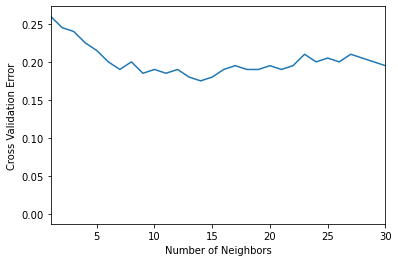

In [14]:
# Put your code here
neighbors = 30
crossvalknn = crossValidationkNN(traindata, trainlabels, neighbors)

plot(np.arange(0, neighbors + 1), crossvalknn)

xlim(1, neighbors)
xlabel("Number of Neighbors")
ylabel("Cross Validation Error")

Select the number of neighbors which minimizes the cross-validation error. What is the cross-validation error for this number of neighbors? <b>(10 points)</b>

In [15]:
# Put your code here
min_neighbors = np.argmin(crossvalknn[1: neighbors + 1]) + 1
print("Minimum Cross Validation Error: {} for k = {} neighbors".format(crossvalknn[min_neighbors], min_neighbors))

Minimum Cross Validation Error: 0.175 for k = 14 neighbors


**[k = 14 and Error: 0.175 or 17.5 %]**

Train a kNN model on the whole training data using the number of neighbors you found in the previous part of the question, and apply it to the test data. Is it higher or lower than the cross-validation error you found in the last part of the problem? **(10 points)**

In [16]:
# Put your code here
neigh = KNeighborsClassifier(n_neighbors=min_neighbors)
neigh.fit(traindata, trainlabels)
predtestlabels = neigh.predict(testdata)

print("Test Error for k = 14: {}".format(np.mean(testlabels != predtestlabels)))

Test Error for k = 14: 0.214


**[Test Error: 0.214 or 21.4 %]**

### Problem 3: Detecting Cancer with SVMs and Logistic Regression (45 points)

We consider the [Breast Cancer Wisconsin Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) from 
W.N. Street, W.H. Wolberg and O.L. Mangasarian. Nuclear feature extraction for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science and Technology, volume 1905, pages 861-870, San Jose, CA, 1993. 

The authors diagnosed people by characterizing 3 cell nuclei per person extracted from the breast (pictures [here](http://web.archive.org/web/19970225174429/http://www.cs.wisc.edu/~street/images/)), each with 10 features (for a 30-dimensional feature space):

1. radius (mean of distances from center to points on the perimeter) 

2. texture (standard deviation of gray-scale values) 

3. perimeter 

4. area 

5. smoothness (local variation in radius lengths) 

6. compactness (perimeter^2 / area - 1.0) 

7. concavity (severity of concave portions of the contour) 

8. concave points (number of concave portions of the contour) 

9. symmetry 

10. fractal dimension ("coastline approximation" - 1)

and classified the sample into one of two classes: Malignant ($+1$) or Benign ($-1$). You can read the original paper for more on what these features mean.

You will be attempting to classify if a sample is Malignant or Benign using Support Vector Machines, as well as Logistic Regression. Since we don't have all that much data, we will use 10-fold cross-validation to tune our parameters for our SVMs and Logistic Regression. We use 90% of the data for training, and 10% for testing.

You will be experimenting with SVMs using Gaussian RBF kernels (through sklearn.svm.SVC), linear SVMs (through sklearn.svm.LinearSVC), and Logistic Regression (sklearn.linear_model.LogisticRegression). 

Your model selection will be done with cross-validation via sklearn.model_selection's *cross_val_score*. This returns the accuracy for each fold, i.e. the fraction of samples classified correctly. Thus, the cross-validation error is simply 1-mean(cross_val_score).

First, we load the data. We will use scikit-learn's train test split function to split the data. The data is scaled for reasons outlined <a href="http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf">here</a>. In short, it helps avoid some numerical issues and avoids some problems with certain features which are typically large affecting the SVM optimization problem unfairly compared to features which are typically small. 

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

cancer = genfromtxt('Data/wdbc.csv', delimiter=',')

np.random.seed(seed=282017) # seed the RNG for repeatability
idx=np.random.permutation(cancer.shape[0])
cancer=cancer[idx]

cancer_features=cancer[:,1:]
cancer_labels=cancer[:,0]

#The training data is in data_train with labels label_train. 
# The test data is in data_test with labels label_test.
data_train, data_test, label_train, label_test = train_test_split(cancer_features,cancer_labels,test_size=0.1,random_state=292017)

# Rescale the training data and scale the test data correspondingly
scaler=MinMaxScaler(feature_range=(-1,1))
data_train=scaler.fit_transform(data_train) #Note that the scaling is determined solely via the training data!
data_test=scaler.transform(data_test)

The soft margin linear SVM is tuned based on a parameter $C$, which controls how much points can be violating the margin (this isn't the same $C$ as in the notes, though it serves the same function; see the [scikit-learn documentation](http://scikit-learn.org/stable/modules/svm.html#svc) for details). 

Use cross-validation to select a value of $C$ for a linear SVM (sklearn.svm.LinearSVC) by varying $C$ from $2^{-5},2^{-4},\ldots,2^{15}$. 

Which value of $C$ would you choose, and why? What is the corresponding cross-validation error? (Note: Some C values will cause a failure to converge, which is okay.) <b>(10 points)</b>

In [22]:
#Put your code here
import warnings
warnings.filterwarnings("ignore")

# list of cross-validated errors for each C
crossvalerr = []

for c in range(-5, 16):
    # classifier
    svc_clf = LinearSVC(C = 2**c)
    
    # cross-validated score
    crossvalscore = cross_val_score(svc_clf, data_train, label_train, cv=10)
    
    # crossvalscore gives accuarcy and not error
    crossvalerr.append(1 - np.mean(crossvalscore))

# c with minimum error    
c = np.argmin(crossvalerr)

# print results
print("C: 2^{}".format(c - 5))
print("Cross Validation Error: {}".format(crossvalerr[c]))

C: 2^-2
Cross Validation Error: 0.025339366515837014


**[C: 2^-2 (0.25) and Error: 0.02534 or 2.534 %]**

You will now experiment with using kernels in an SVM, particularly the Gaussian RBF kernel (in sklearn.svm.SVC). The SVM has two parameters to tune in this case: $C$ (as before), and $\gamma$, which is a parameter in the RBF. 

Use cross-validation to select parameters $(C,\gamma)$ by searching varying $(C,\gamma)$ over $C=2^{-5},2^{-4},\ldots,2^{15}$ and $\gamma=2^{-15},\ldots,2^{3}$ [So, you will try about 400 parameter choices]. This procedure is known as a **grid search**. Use *GridSearchCV* (see doc [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) to perform a grid search (and you can use *clf.best\_params
_* to get the best parameters). Out of these, which $(C,\gamma)$ parameters would you choose? What is the corresponding cross-validation error?

We are using a fairly coarse grid for this problem, but one could use a finer grid once the rough range of good parameters is known (rather than starting with a fine grid, which would waste a lot of time). <b>(10 points)</b>

In [19]:
# Put your code here
# parameters to search
params = {'C': [2 ** c for c in range(-5, 16)], 'gamma': [2 ** c for c in range(-15, 4)]}

# classifier
svm_clf = GridSearchCV(svm.SVC(kernel='rbf'), params, cv=10)
svm_clf.fit(data_train, label_train)

# cross validated accuracy and best parameters
bestparams = svm_clf.best_params_
svm_crossvalacc = svm_clf.cv_results_['mean_test_score'][np.argwhere(np.array(svm_clf.cv_results_['params']) == bestparams)][0][0]

# print results
print("C: 2^{} and Gamma: 2^{}".format(int(np.log2(bestparams['C'])), int(np.log2(bestparams['gamma']))))
print("Cross Validation Error: {}".format(1 - svm_crossvalacc))

C: 2^3 and Gamma: 2^-3
Cross Validation Error: 0.0195324283559577


**[C: 2^3 (8); gamma: 2^-3 (0.125) and Error: 0.01953 or 1.953 %]**

As stated in a footnote in the notes, Logistic Regression normally has a regularizer parameter to promote stability. Scikit-learn calls this parameter $C$ (which is like $\lambda^{-1}$ in the notes); see the [LibLinear](http://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf) documentation for the exact meaning of $C$. 

Use cross-validation to select a value of $C$ for logistic regression (sklearn.linear_model.LogisticRegression) by varying $C$ from $2^{-14},\ldots,2^{14}$. You may optionally make use of sklearn.model_selection.GridSearchCV, or write the search by hand. 

Which value of $C$ would you choose? What is the corresponding cross-validation error? **(5 points)**

In [20]:
#Put your code here
# parameters to search
params = {'C': [2 ** c for c in range(-14, 15)]}

# classifier
lr_clf = GridSearchCV(LogisticRegression(), params, cv=10)
lr_clf.fit(data_train, label_train)

# cross validated accuracy and best parameters
bestparams = lr_clf.best_params_
lr_crossvalacc = lr_clf.cv_results_['mean_test_score'][np.argwhere(np.array(lr_clf.cv_results_['params']) == bestparams)][0][0]

# print results
print("C: 2^{}".format(int(np.log2(bestparams['C']))))
print("Cross Validation Error: {}".format(1 - lr_crossvalacc))

C:\Users\achan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\achan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\achan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\achan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\achan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\achan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\achan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\achan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\achan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\achan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C: 2^0
Cross Validation Error: 0.021455505279034726


C:\Users\achan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\achan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

**[C: 2^0 (1) and Error: 0.02145 or 2.145 %]**

Based on the classifiers you selected thusfar for Linear SVM, SVM + Gaussian RBF and Logistic Regression, which classifier would you pick? Make sure to take into account error, the application and computational considerations. **(5 points)**

**[Based on the above classifiers I would pick the radial basis function (RBF) SVM because it appears to have the smallest cross-validation error. However, the above implementation performs lots of computations (for classfying as well as searching for the best parameters) but the gain in Cross Validation accuracy appears to significant]**

Train the classifier selected above on the whole training set. Then, estimate the prediction error using the test set. What is your estimate of the prediction error? How does it compare to the cross-validation error?  <b>(10 points)</b>

In [21]:
#Put your code here
# classifier
clf = svm.SVC(kernel='rbf', C=2**3, gamma=2**-3)

# fit SVC classifier on whole training set
clf.fit(data_train, label_train)

# prediction on test data
predtestlabels = clf.predict(data_test)

# print test error
print("Test Error: {}".format(np.mean(predtestlabels != label_test)))

Test Error: 0.017543859649122806


**[Test Error: 0.01754 or 1.754 %]**

Do you think the 0,1-loss is appropriate performance measure to report, in this case? If so, why? If not, how would you measure performance? **(5 points)**

**[The 0,1-loss isn't an appropriate performance measure because in the case of SVM we are attempting to maximize the definition of the "margin" which is used to seperate the data. Therefore, allowing for gradation (rather than a binary measure) is a better measure of performance because it indicates how far away our data points are from a decision boundry. A better measure of performance is the hinge loss function which controls the size of the margin]**

## And this concludes Lab 3! Congratulations!